In [2]:
# ---------------- Complete Dataset without Augmentation ----------------
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from google.colab import drive

In [3]:
# !pip install albumentations
# !pip install torch torchvision
# !pip install pandas

In [4]:
# ---------------- Google Drive ----------------
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# ---------------- Config ----------------
#csv_path = '/content/drive/MyDrive/streetSurfaceVis_v1_0.csv'
csv_path = 'streetSurfaceVis_v1_0.csv'
img_folder = '/content/drive/MyDrive/s_1024'

SURFACE_TYPE_MAP = {"asphalt":0,"concrete":1,"paving_stones":2,"unpaved":3,"sett":4}
SURFACE_QUALITY_MAP = {"excellent":0,"good":1,"intermediate":2,"bad":3,"very_bad":4}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# ---------------- Augmentation DISABLED ----------------
# Just resize + convert to tensor
augmentations = A.Compose([
    A.Resize(288,512),
    ToTensorV2()
])

In [10]:
# # ---------------- Load CSV and generate dataset ----------------
df = pd.read_csv(csv_path)
images_list, main_labels_list, sub_labels_list = [], [], []
missing_files = []

# for _, row in df.iterrows():
#     path = os.path.join(img_folder, f"{row['mapillary_image_id']}.jpg")
#     if not os.path.exists(path):
#         missing_files.append(row['mapillary_image_id'])
#         continue  # skip missing files

#     img = Image.open(path).convert('RGB')
#     img_np = np.array(img)

#     # only one copy, no augmentation
#     img_tensor = augmentations(image=img_np)['image']
#     images_list.append(img_tensor)
#     main_labels_list.append(SURFACE_TYPE_MAP[row['surface_type']])
#     sub_labels_list.append(SURFACE_QUALITY_MAP[row['surface_quality']])

# print(f"⚠️ Skipped {len(missing_files)} missing images")
# if missing_files:
#     print("Missing image IDs:", missing_files)

In [11]:
class StreetSurfaceDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_folder, transform=None, n_aug=3):
        self.df = df.reset_index(drop=True)
        self.img_folder = img_folder
        self.transform = transform
        self.n_aug = n_aug

    def __len__(self):
        return len(self.df) * (1 + self.n_aug)  # original + augmentations

    def __getitem__(self, idx):
        real_idx = idx // (1 + self.n_aug)

        row = self.df.iloc[real_idx]
        img_path = os.path.join(self.img_folder, f"{row['mapillary_image_id']}.jpg")

        if not os.path.exists(img_path):
            # Handle missing files - return a black image or skip
            img_tensor = torch.zeros(3, 288, 512)
        else:
            img = Image.open(img_path).convert('RGB')
            img_np = np.array(img)

            if self.transform:
                img_tensor = self.transform(image=img_np)['image']
            else:
                img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)

        main_label = SURFACE_TYPE_MAP[row['surface_type']]
        sub_label = SURFACE_QUALITY_MAP[row['surface_quality']]

        return img_tensor.float(), main_label, sub_label

# Create dataset with the new class
dataset = StreetSurfaceDataset(df, img_folder, transform=augmentations, n_aug=3)

In [12]:
# # ---------------- Convert to tensors and create TensorDataset ----------------
# images_tensor = torch.stack(images_list)
# main_labels_tensor = torch.tensor(main_labels_list)
# sub_labels_tensor = torch.tensor(sub_labels_list)

# dataset = TensorDataset(images_tensor, main_labels_tensor, sub_labels_tensor)

In [13]:
# ---------------- Train/Val/Test Split ----------------
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

In [14]:
# ---------------- Model ----------------
backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_feat = backbone.fc.in_features
backbone.fc = nn.Identity()
backbone = backbone.to(device)

fc_main = nn.Linear(in_feat, len(SURFACE_TYPE_MAP)).to(device)
fc_sub = nn.Linear(in_feat, len(SURFACE_QUALITY_MAP)).to(device)

optimizer = optim.Adam(
    list(backbone.parameters()) + list(fc_main.parameters()) + list(fc_sub.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [15]:
# ---------------- Training Loop (1 epoch) ----------------
best_val_loss = float('inf')
epochs = 15

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

best_val_joint_acc = 0.0

for epoch in range(epochs):
    backbone.train(); fc_main.train(); fc_sub.train()
    train_loss = 0.0
    for images, main_labels, sub_labels in train_loader:
        images = images.to(device).float()
        main_labels = main_labels.to(device)
        sub_labels = sub_labels.to(device)

        optimizer.zero_grad()
        features = backbone(images)
        out_main = fc_main(features)
        out_sub = fc_sub(features)
        loss = criterion(out_main, main_labels) + criterion(out_sub, sub_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    backbone.eval(); fc_main.eval(); fc_sub.eval()
    val_loss = 0.0
    correct_main = 0
    correct_sub = 0
    correct_joint = 0
    total_samples = 0

    with torch.no_grad():
        for images, main_labels, sub_labels in val_loader:
            images = images.to(device).float()
            main_labels = main_labels.to(device)
            sub_labels = sub_labels.to(device)
            features = backbone(images)
            out_main = fc_main(features)
            out_sub = fc_sub(features)
            loss = criterion(out_main, main_labels) + criterion(out_sub, sub_labels)
            val_loss += loss.item()

            _, predicted_main = torch.max(out_main.data, 1)
            _, predicted_sub = torch.max(out_sub.data, 1)

            correct_main += (predicted_main == main_labels).sum().item()
            correct_sub += (predicted_sub == sub_labels).sum().item()
            correct_joint += ((predicted_main == main_labels) & (predicted_sub == sub_labels)).sum().item()
            total_samples += main_labels.size(0)


    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_main_acc = correct_main / total_samples
    val_sub_acc = correct_sub / total_samples
    val_joint_acc = correct_joint / total_samples

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Main Acc: {val_main_acc:.4f} | Val Sub Acc: {val_sub_acc:.4f} | Val Joint Acc: {val_joint_acc:.4f}")

    scheduler.step(avg_val_loss)

    # Save model based on joint accuracy
    if val_joint_acc > best_val_joint_acc:
        best_val_joint_acc = val_joint_acc
        torch.save({
            'backbone': backbone.state_dict(),
            'fc_main': fc_main.state_dict(),
            'fc_sub': fc_sub.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_val_joint_acc': best_val_joint_acc
        }, "best_model.pth")
        print("✅ Model checkpoint saved based on joint accuracy.")

Epoch 1 | Train Loss: 2.9108 | Val Loss: 2.9870 | Val Main Acc: 0.4014 | Val Sub Acc: 0.3437 | Val Joint Acc: 0.1763
✅ Model checkpoint saved based on joint accuracy.
Epoch 2 | Train Loss: 2.8990 | Val Loss: 3.3605 | Val Main Acc: 0.2264 | Val Sub Acc: 0.2964 | Val Joint Acc: 0.0618


KeyboardInterrupt: 

In [ ]:
# ---------------- Display 3 example images ----------------
for i in range(3):
    plt.imshow(np.transpose(images_tensor[i].numpy(), (1,2,0)))
    plt.title(f"Type: {main_labels_tensor[i].item()}, Quality: {sub_labels_tensor[i].item()}")
    plt.axis('off')
    plt.show()

In [ ]:
IDX2TYPE = [k for k,_ in sorted(SURFACE_TYPE_MAP.items(), key=lambda kv: kv[1])]
IDX2QUAL = [k for k,_ in sorted(SURFACE_QUALITY_MAP.items(), key=lambda kv: kv[1])]

In [ ]:
IDX2TYPE

['asphalt', 'concrete', 'paving_stones', 'unpaved', 'sett']

Epoch 1 | TrainLoss 0.0375 | Val Acc(main) 0.996 | Val Acc(sub) 0.984 | Val MacroF1(main) 0.995 | Val MacroF1(sub) 0.986 | Val JointAcc 0.982
✅ Saved checkpoint (best joint accuracy).
Epoch 2 | TrainLoss 0.0349 | Val Acc(main) 0.997 | Val Acc(sub) 0.980 | Val MacroF1(main) 0.996 | Val MacroF1(sub) 0.981 | Val JointAcc 0.978
Epoch 3 | TrainLoss 0.0330 | Val Acc(main) 0.997 | Val Acc(sub) 0.980 | Val MacroF1(main) 0.996 | Val MacroF1(sub) 0.980 | Val JointAcc 0.978
Epoch 4 | TrainLoss 0.0308 | Val Acc(main) 0.998 | Val Acc(sub) 0.983 | Val MacroF1(main) 0.997 | Val MacroF1(sub) 0.984 | Val JointAcc 0.982
Epoch 5 | TrainLoss 0.0312 | Val Acc(main) 0.994 | Val Acc(sub) 0.970 | Val MacroF1(main) 0.993 | Val MacroF1(sub) 0.975 | Val JointAcc 0.966
Epoch 6 | TrainLoss 0.0317 | Val Acc(main) 0.996 | Val Acc(sub) 0.973 | Val MacroF1(main) 0.995 | Val MacroF1(sub) 0.977 | Val JointAcc 0.970
Epoch 7 | TrainLoss 0.0336 | Val Acc(main) 0.999 | Val Acc(sub) 0.983 | Val MacroF1(main) 0.998 | Val Macr

In [21]:
checkpoint = torch.load("best_model.pth")

backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_feat = backbone.fc.in_features
backbone.fc = nn.Identity()
backbone = backbone.to(device)

fc_main = nn.Linear(in_feat, len(SURFACE_TYPE_MAP)).to(device)
fc_sub = nn.Linear(in_feat, len(SURFACE_QUALITY_MAP)).to(device)

backbone.load_state_dict(checkpoint['backbone'])
fc_main.load_state_dict(checkpoint['fc_main'])
fc_sub.load_state_dict(checkpoint['fc_sub'])

<All keys matched successfully>

In [22]:
backbone.eval()
fc_main.eval()
fc_sub.eval()

all_main_labels = []
all_sub_labels = []
all_main_preds = []
all_sub_preds = []

with torch.no_grad():
    for images, main_labels, sub_labels in test_loader:
        images = images.to(device).float()
        main_labels = main_labels.to(device)
        sub_labels = sub_labels.to(device)

        features = backbone(images)
        out_main = fc_main(features)
        out_sub = fc_sub(features)

        _, predicted_main = torch.max(out_main.data, 1)
        _, predicted_sub = torch.max(out_sub.data, 1)

        all_main_labels.extend(main_labels.cpu().numpy())
        all_sub_labels.extend(sub_labels.cpu().numpy())
        all_main_preds.extend(predicted_main.cpu().numpy())
        all_sub_preds.extend(predicted_sub.cpu().numpy())

all_main_labels = np.array(all_main_labels)
all_sub_labels = np.array(all_sub_labels)
all_main_preds = np.array(all_main_preds)
all_sub_preds = np.array(all_sub_preds)

In [23]:
from sklearn.metrics import confusion_matrix

main_confusion_matrix = confusion_matrix(all_main_labels, all_main_preds)
sub_confusion_matrix = confusion_matrix(all_sub_labels, all_sub_preds)

print("Main Task Confusion Matrix:")
display(main_confusion_matrix)
print("\nSub Task Confusion Matrix:")
display(sub_confusion_matrix)

Main Task Confusion Matrix:


array([[2290,    0,    0,    0,    0],
       [ 597,    0,    0,    0,    0],
       [1237,    0,    0,    0,    0],
       [ 611,    0,    0,    0,    0],
       [ 739,    0,    0,    0,    0]])


Sub Task Confusion Matrix:


array([[   0, 1056,    0,    0,    0],
       [   0, 1993,    0,    0,    0],
       [   0, 1461,    0,    0,    0],
       [   0,  793,    0,    0,    0],
       [   0,  171,    0,    0,    0]])

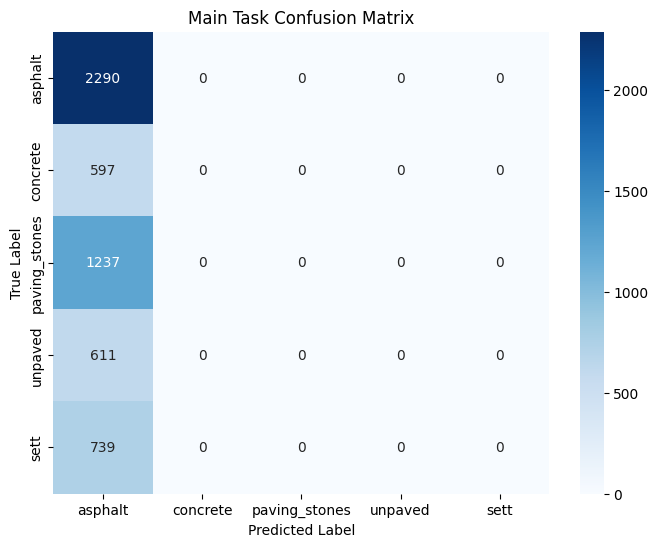

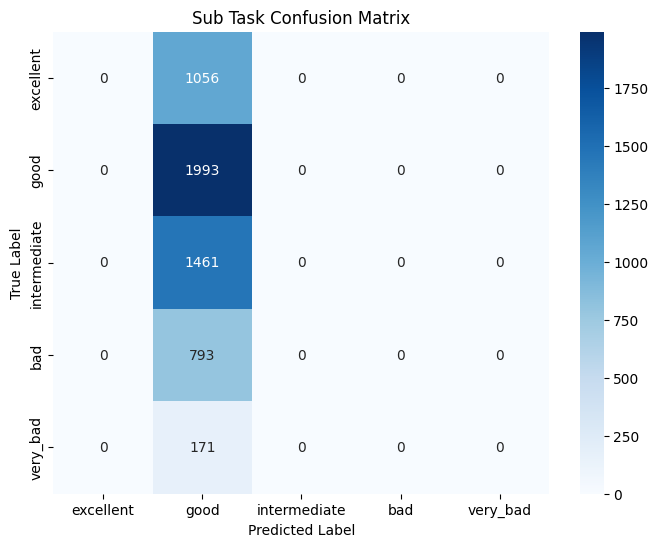

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(main_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=IDX2TYPE, yticklabels=IDX2TYPE)
plt.title("Main Task Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(sub_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=IDX2QUAL, yticklabels=IDX2QUAL)
plt.title("Sub Task Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()